In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import complexPyTorch as ctorch
from complexPyTorch import complexFunctions, complexLayers
from complexPyTorch.complexFunctions import complex_tanh

plt.rcParams['text.usetex']=True

In [60]:
delta=0.01
mass=1

In [61]:
class BosonWaveFunction(nn.Module):
    def __init__(self):
        super(BosonWaveFunction, self).__init__()

        self.layer1=nn.Linear(1,128)
        self.layer2=nn.Linear(128,128)
        self.layer3=nn.Linear(128,1)

        self.norm = torch.ones(1, requires_grad=False)
        
        self.exp_factor = torch.ones(1)

    def forward(self, inputs):
        x = inputs
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        x = torch.tanh(x)
        x = self.layer3(x)

        # boundary condition - normalization?
        # boundary_condition = self.exp(inputs)
        # output = self.norm*x*boundary_condition
        
        boundary_condition = torch.exp( -(self.exp_factor*inputs)**2/2 )
        factor = self.norm*boundary_condition
        #x = torch.mul(x,self.norm)

        x = torch.mul(x,factor)

        return x
    
    def update_norm(self, inputs):
        with torch.no_grad():
            value = self.forward(inputs)
            N = value**2
            delta=inputs[1]-inputs[0]
            N=torch.sum(N)*delta 
            self.norm = self.norm*1.0/torch.sqrt(N)

In [62]:
class FermionWaveFunction(nn.Module):
    def __init__(self):
        super(FermionWaveFunction, self).__init__()

        self.layer1=ctorch.complexLayers.ComplexLinear(1,128)
        self.layer2=ctorch.complexLayers.ComplexLinear(128,128)
        self.layer3=ctorch.complexLayers.ComplexLinear(128,1) # or (32,2)

        self.norm = torch.ones(1, requires_grad=False)

        self.exp_factor = torch.ones(1)

    def forward(self, inputs):
        x = inputs.type(torch.complex64)
        x = self.layer1(x)
        x = ctorch.complexFunctions.complex_tanh(x)
        x = self.layer2(x)
        x = ctorch.complexFunctions.complex_tanh(x)
        x = self.layer3(x)

        # boundary condition - normalization?
        # boundary_condition = self.exp(inputs)
        # output = self.norm*x*boundary_condition
        
        boundary_condition = torch.exp( -(self.exp_factor*inputs)**2/2 )
        factor = self.norm*boundary_condition
        #x = torch.mul(x,self.norm)

        x = torch.mul(x,factor)

        return x

    def update_norm(self, inputs):
        with torch.no_grad():
            value = self.forward(inputs)
            N = torch.mul(value.conj(),value)
            #N = torch.inner(value.conj(),value).real
            delta=inputs[1]-inputs[0]
            N=torch.sum(N)*delta
            self.norm = self.norm*1.0/torch.sqrt(N)

In [63]:
# This is preparing input data that is differentiable:
_x = np.arange(-10, 10, delta, dtype=np.float32)
_x = _x.reshape((_x.shape[0], 1))
x = torch.tensor(_x, requires_grad=True)

In [64]:
phi = BosonWaveFunction()
print(phi.norm)
phi.update_norm(x)
print(phi.norm)
phi_y = phi(x)

tensor([1.])
tensor([9.0916])


In [65]:
psi = FermionWaveFunction()
print(psi.norm)
psi.update_norm(x)
print(psi.norm)
psi_y = psi(x)
print(psi_y.shape)

tensor([1.])
tensor([1.8808+0.j])
torch.Size([2000, 1])


In [66]:
(phi_y**2).shape

torch.Size([2000, 1])

In [67]:
torch.einsum('ij,ij->i',psi_y.conj(),psi_y)

tensor([4.4842e-44+0.j, 5.3249e-44+0.j, 6.7262e-44+0.j,  ..., 6.5861e-44+0.j,
        5.4651e-44+0.j, 4.4842e-44+0.j], grad_fn=<ViewBackward0>)

/home/chris/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


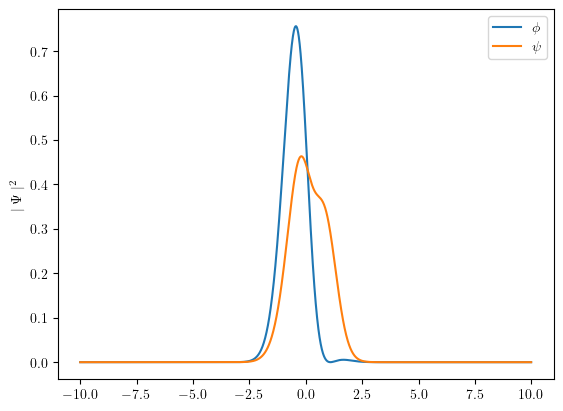

In [68]:
plt.plot(x.detach().numpy(), (phi_y**2).detach().numpy(), label=r'$\phi$')
plt.plot(x.detach().numpy(), (psi_y.conj()*psi_y).detach().numpy(), label=r'$\psi$')
# plt.plot(x.detach().numpy(), (torch.einsum('ij,ij->i',psi_y.conj(),psi_y)).detach().numpy(), label=r'$\psi$')
plt.ylabel(r'$\mid\Psi\mid^2$')
plt.legend()
plt.show()

In [73]:
def bosonic_kinetic_energy(boson_wf, inputs, delta):
    phi = boson_wf(inputs) # phi(x)
    dPhidx = torch.autograd.grad(phi, inputs=inputs, grad_outputs=torch.ones_like(phi), retain_graph=True)

    t1 = dPhidx[0]**2/(2.0*delta) # p_n^2/2a
    t2 = ((phi.roll(-1)-phi.roll(1))/(2.0*delta))**2 #(phi_{n+1}-phi_{n-1})^2/2a

    return torch.sum(t1) + (delta/2.0)*torch.sum(t2)

def boson_potential_energy(boson_wf, inputs, delta):
    phi = boson_wf(inputs)

    #t1 = potential(boson_wf, inputs)**2 # V(phi_n)^2
    #t2 = potential(boson_wf, inputs)*(phi.roll(1)-phi.roll(-1)) # V(phi_n)*(phi_{n+1}-phi_{n-1})

    t1 = phi**2
    t2 = phi*(phi.roll(-1)-phi.roll(+1))  

    return (delta/2.0)*torch.sum(t1) + (1.0/2.0)*torch.sum(t2)

    # TODO: this is delta/2????

def fermion_kinetic_energy(fermion_wf, inputs, delta):
    chi = fermion_wf(inputs)

    t1 = (chi.conj())*(chi.roll(-1))
    t2 = (chi.conj().roll(-1))*chi
    
    #t1 = torch.einsum('ij,ij->i',chi.conj(),chi.roll(1))
    #t2 = torch.einsum('ij,ij->i',chi.conj().roll(1),chi)

    return (torch.sum(t1)+torch.sum(t2))/(2.0*delta)

def fermion_potential_energy(fermion_wf, boson_wf, inputs, delta):
    chi = fermion_wf(inputs)

    minus1n = torch.tensor([(-1)**n for n in range(chi.shape[0])])
    half = torch.tensor([0.5 for n in range(chi.shape[0])])

    # TODO: Why the double sum? 
    return torch.sum(minus1n*(torch.sum(chi.conj()*chi)-half))
    #return torch.sum(minus1n*(torch.einsum('ij,ij->i',chi.conj(),chi)-half))

In [74]:
print(bosonic_kinetic_energy(phi, x, delta))
print(boson_potential_energy(phi, x, delta))
print(fermion_kinetic_energy(psi, x, delta))
print(fermion_potential_energy(psi, phi, x, delta))

tensor(4862.0820, grad_fn=<AddBackward0>)
tensor(0.5000, grad_fn=<AddBackward0>)
tensor(9999.2471+0.j, grad_fn=<DivBackward0>)
tensor(0.+0.j, grad_fn=<SumBackward0>)


In [75]:
print(bosonic_kinetic_energy(phi, x, delta) \
    + boson_potential_energy(phi, x, delta) \
    + fermion_kinetic_energy(psi, x, delta) \
    + fermion_potential_energy(psi, phi, x, delta))

tensor(14861.8291+0.j, grad_fn=<AddBackward0>)


In [76]:
def normalization(boson_wf, fermion_wf, inputs, delta):
    phi2 = boson_wf(inputs)**2
    psi = fermion_wf(inputs)

    return torch.sum(psi.adjoint()*psi)*torch.sum(phi2)*delta
    # return torch.sum(psi.adjoint()*psi*phi2)*delta

def total_energy(boson_wf, fermion_wf, inputs, delta):
    bosonKE = bosonic_kinetic_energy(boson_wf, inputs, delta)
    bosonPE = boson_potential_energy(boson_wf, inputs, delta)
    fermionKE = fermion_kinetic_energy(fermion_wf, inputs, delta)
    fermionPE = fermion_potential_energy(fermion_wf, boson_wf, inputs, delta)

    return (bosonKE + bosonPE + fermionKE + fermionPE)#/normalization(boson_wf,fermion_wf,inputs,delta)


In [77]:
total_energy(phi, psi, x, delta)

tensor(14861.8291+0.j, grad_fn=<AddBackward0>)

In [78]:
bosonOptimizer = torch.optim.Adam(phi.parameters(), lr=0.001)
fermionOptimizer = torch.optim.Adam(psi.parameters(), lr=0.001)

bosonOptimizer.zero_grad()
fermionOptimizer.zero_grad()

# cant go up to 10000?
for i in range(1000):
    phi.update_norm(x)
    psi.update_norm(x)

    energy=total_energy(phi,psi,x,delta).real # this is the loss!
    energy.backward()

    if i%2==0:
        bosonOptimizer.step()
        bosonOptimizer.zero_grad()
    else:
        fermionOptimizer.step()
        fermionOptimizer.zero_grad()
    
    if i%100==0:
        print(energy)

tensor(14861.8301, grad_fn=<SelectBackward0>)
tensor(18715.9355, grad_fn=<SelectBackward0>)
tensor(13119.0723, grad_fn=<SelectBackward0>)
tensor(13103.6562, grad_fn=<SelectBackward0>)
tensor(16600.7344, grad_fn=<SelectBackward0>)
tensor(18374.7090, grad_fn=<SelectBackward0>)
tensor(13463.6143, grad_fn=<SelectBackward0>)
tensor(13067.9453, grad_fn=<SelectBackward0>)
tensor(13014.2764, grad_fn=<SelectBackward0>)


KeyboardInterrupt: 

In [50]:
print(bosonic_kinetic_energy(phi, x, delta))
print(boson_potential_energy(phi, x, delta))
print(fermion_kinetic_energy(psi, x, delta))
print(fermion_potential_energy(psi, phi, x, delta))

tensor(52.6608, grad_fn=<AddBackward0>)
tensor(0.0025, grad_fn=<AddBackward0>)
tensor(199.9941+0.j, grad_fn=<DivBackward0>)
tensor(0.+0.j, grad_fn=<MulBackward0>)


/home/chris/anaconda3/envs/MachineLearning/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


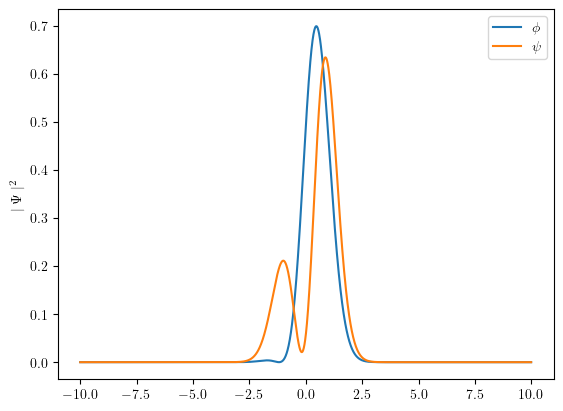

In [79]:
phi_y = phi(x)
psi_y = psi(x)
plt.plot(x.detach().numpy(), (phi_y**2).detach().numpy(), label=r'$\phi$')
plt.plot(x.detach().numpy(), (psi_y.conj()*psi_y).detach().numpy(), label=r'$\psi$')
# plt.plot(x.detach().numpy(), (torch.einsum('ij,ij->i',psi_y.conj(),psi_y)).detach().numpy(), label=r'$\psi$')
plt.ylabel(r'$\mid\Psi\mid^2$')
plt.legend()
plt.show()